In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

PATH_FOLDER = "MovieSummaries/"

In [8]:
budget = pd.read_csv("movies.csv")
budget = budget.dropna()
budget = budget[["name", "budget", "company", "score", "rating"]]
budget = budget.rename(columns={"name" : "Movie_name"})

budget_final = budget.copy()

budget.columns

Index(['Movie_name', 'budget', 'company', 'score', 'rating'], dtype='object')

In [9]:
budget['budget'] = (budget['budget'] - budget['budget'].min()) / (budget['budget'].max() - budget['budget'].min())
budget['score'] = (budget['score'] - budget['score'].min()) / (budget['score'].max() - budget['score'].min())
budget
# One-hot encode 'company' and 'rating' columns
budget = pd.get_dummies(budget, columns=[ 'company','rating'], prefix=['company','rating'])
budget

,Movie_name,budget,score,"company_""DIA"" Productions GmbH & Co. KG","company_""Weathering With You"" Film Partners",company_.406 Production,company_1492 Pictures,company_1818 Productions,company_19 Entertainment,company_1978 Films,...,rating_Approved,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_TV-MA,rating_Unrated,rating_X
0,The Shining,0.053355,0.878378,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,The Blue Lagoon,0.012624,0.527027,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,Star Wars: Episode V - The Empire Strikes Back,0.050546,0.918919,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,Airplane!,0.009815,0.783784,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,Caddyshack,0.016837,0.729730,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,Bad Boys for Life,0.252796,0.635135,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7649,Sonic the Hedgehog,0.238751,0.621622,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
7650,Dolittle,0.491564,0.500000,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
7651,The Call of the Wild,0.379203,0.662162,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [10]:
x = pd.read_csv("final_version_dataset.csv")
x = x.dropna()
final = x.copy()
x["Movie_name"] = x["Movie_name"].astype(str)
x = pd.merge(x, budget, on="Movie_name")
x = x.dropna()

In [11]:
final = pd.merge(final, budget_final, on="Movie_name").dropna()

Y = x['log_revenues']
X = x.drop(columns=["log_revenues","Unnamed: 0", "Movie ID","Movie_name"])  # Include more variables as needed
X = sm.add_constant(X)  # Adds a constant term to the predictor
# Select columns to one-hot encode
X['Month'] = X['Month'].astype('category')
X["Percentage_Women"]  = X["Percentage_Women"]/100
categorical_cols = ["Month",'pos_Interval', 'neg_Interval', 'runtime_Interval']

# Apply one-hot encoding
encoded_cols = pd.get_dummies(X[categorical_cols])

# Join the encoded dataframe with the original dataframe
X = X.join(encoded_cols).drop(columns=categorical_cols)
X = X.astype(float)
X

,const,Percentage_Women,specific_actors_ratio,specific_countries_ratio,specific_languages_ratio,Action,Action/Adventure,Adventure,Comedy,Crime Fiction,...,neg_Interval_0-2,neg_Interval_2-4,neg_Interval_4-6,neg_Interval_6-8,neg_Interval_8-10,runtime_Interval_0-60,runtime_Interval_120-180,runtime_Interval_180-240,runtime_Interval_240-1000,runtime_Interval_60-120
0,1.0,0.35,0.117647,1.0,1.0,0.142857,0.000000,0.142857,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.52,0.043478,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.35,0.250000,1.0,1.0,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.47,0.176471,1.0,1.0,0.000000,0.000000,0.000000,0.142857,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.50,0.590909,1.0,1.0,0.000000,0.000000,0.000000,0.250000,0.250000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1.0,0.53,0.076923,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3197,1.0,0.21,0.142857,1.0,1.0,0.000000,0.000000,0.125000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3198,1.0,0.37,0.000000,1.0,1.0,0.142857,0.142857,0.000000,0.000000,0.142857,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3199,1.0,0.37,0.250000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
model = sm.OLS(Y,X).fit()

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get the predicted values
y_pred = model.predict(X)

# Calculate MAE
mae = mean_absolute_error(Y, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y, y_pred))

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

print(model.summary())

Mean Absolute Error (MAE): 0.6181259670816108
Root Mean Squared Error (RMSE): 0.9039816570044049
                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     6.038
Date:                Thu, 21 Dec 2023   Prob (F-statistic):          2.10e-261
Time:                        19:04:05   Log-Likelihood:                -4218.9
No. Observations:                3201   AIC:                         1.015e+04
Df Residuals:                    2345   BIC:                         1.535e+04
Df Model:                         855                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   3.,   5.,   5.,
          2.,   3.,   5.,   5.,   7.,   7.,   5.,  12.,  14.,  29.,  20.,
         41.,  55.,  68.,  83.,  90., 124., 170., 193., 216., 781., 217.,
        207., 221., 174., 132.,  96.,  67.,  53.,  29.,  23.,  17.,   6.,
          5.,   2.,   1.,   1.,   0.,   3.]),
 array([-5.76164619, -5.57742863, -5.39321108, -5.20899352, -5.02477597,
        -4.84055842, -4.65634086, -4.47212331, -4.28790575, -4.1036882 ,
        -3.91947064, -3.73525309, -3.55103553, -3.36681798, -3.18260042,
        -2.99838287, -2.81416531, -2.62994776, -2.44573021, -2.26151265,
        -2.0772951 , -1.89307754, -1.70885999, -1.52464243, -1.34042488,
        -1.15620732, -0.97198977, -0.78777221, -0.60355466, -0.41933711,
        -0.23511955, -0.050902  ,  0.13331556,  0.31753311,  0.50175067,
         0.68596822,  0.87018578,  1.05440333,  1.23862089,  1.42283844,
         1.607056  ,  1.79127355,  1.9754911 ,  2.15970866,  2.34392621,
 

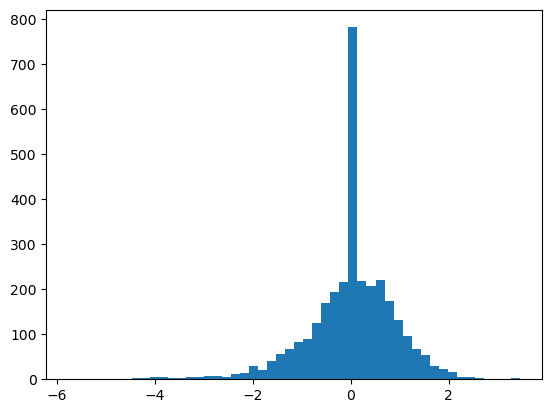

In [13]:
plt.hist(Y- y_pred,bins=50)

In [14]:
threshold = 1.5
# Calculate the absolute difference
abs_diff = Y - y_pred

# Get the indices where abs_diff is larger than 2
indices_below = np.where(abs_diff > threshold)
indices_above = np.where(abs_diff < -threshold)
# Print the indices
print(f"Indices where abs_diff > {threshold}:", indices_below[0].shape)
print(f"Indices where abs_diff < -{threshold}:", indices_above[0].shape)

Indices where abs_diff > 1.5: (116,)
Indices where abs_diff < -1.5: (176,)


In [15]:
outliers_below = final.iloc[indices_below[0]]
outliers_above = final.iloc[indices_above[0]]
columns_to_consider = ['Month', 'Percentage_Women',
       'pos_Interval', 'neg_Interval', 'runtime_Interval',
       'specific_actors_ratio', 'specific_countries_ratio',
       'specific_languages_ratio',
       'budget', 'company', 'score', 'rating']

outliers_below.shape
below_list, above_list = [] , []

for col in columns_to_consider :
    condition_below = outliers_below[col].unique().shape[0]/final[col].unique().shape[0]
    condition_above = outliers_above[col].unique().shape[0]/final[col].unique().shape[0]

    if condition_below < 0.5: 
        print("below ", col , " ",  outliers_below[col].unique() , " \n", final[col].unique()) 
        below_list.append(col)
    if condition_above < 0.5: 
        print("above ", col , " ",  outliers_above[col].unique() , " \n", final[col].unique()) 
        above_list.append(col)

above  runtime_Interval   ['60-120' '120-180']  
 ['60-120' '120-180' '180-240' '240-1000' '0-60']
below  specific_actors_ratio   [0.36363636 0.21052632 0.375      0.2        0.33333333 0.28571429
 0.14285714 0.06666667 0.         0.46153846 0.20512821 0.13333333
 0.125      0.0952381  0.42857143 0.05263158 0.08695652 0.21428571
 0.5        0.22222222 0.1        0.25       0.18181818 0.07142857
 0.4        0.43589744 0.23076923 0.03030303 0.22580645 0.16666667
 0.17647059 0.41666667 0.63636364 0.3125     0.15789474 0.11111111
 0.6        0.05882353 0.26315789 0.15384615 0.66666667 0.23529412
 0.08333333 0.4375     0.24       0.42105263 0.72727273 0.625
 0.08823529 0.27272727 0.41176471 0.15       0.58333333 0.83333333
 0.3       ]  
 [0.11764706 0.04347826 0.25       0.17647059 0.59090909 0.1875
 0.07692308 0.21052632 0.18181818 0.16666667 0.11111111 0.22222222
 0.33333333 0.28571429 0.2        0.66666667 0.36363636 0.09090909
 0.38461538 0.         0.14285714 0.375      0.44444444 0.4

In [16]:
print(above_list)
print(below_list)

['runtime_Interval', 'specific_actors_ratio', 'specific_countries_ratio', 'specific_languages_ratio', 'budget', 'company']
['specific_actors_ratio', 'specific_countries_ratio', 'specific_languages_ratio', 'budget', 'company']


# outlier analysis

In [17]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

import re

def transform_string(input_string):
    # Use regular expression to match 'specific_<word>_ratio' pattern
    match = re.match(r'specific_(\w+)_ratio', input_string)
    
    if match:
        # Extract the word and transform it
        word = match.group(1)
        transformed_string = f"{word.capitalize()}"
        return transformed_string
    else:
        # Return the input string unchanged if it doesn't match the pattern
        return input_string


# Functions
def generate_runtime_interval_pie_chart(dataframe, final_data):
    data_runtime_interval = dataframe['runtime_Interval'].value_counts()
    for category in final_data['runtime_Interval'].value_counts().index:
        if category not in data_runtime_interval.index:
            data_runtime_interval[category] = 0
    #text = [f'{value:.2f}%' for value in data_runtime_interval.values / data_runtime_interval.sum() * 100]
    #return go.Pie(labels=data_runtime_interval.index, values=data_runtime_interval.values, text=text, textinfo='label+percent', name="Runtime Interval", hoverinfo='label+percent+name')
    return go.Pie(labels=data_runtime_interval.index, values=data_runtime_interval.values, 
                  textinfo='label+percent', name="Runtime", 
                  hoverinfo='label+percent+name')


def generate_actors_ratio_pie_chart(dataframe,feature_name ):
    bins = np.linspace(0, 1, 5)  # Creates 4 intervals from 0 to 1
    labels = [f'{int(x*100)}-{int(y*100)}%' for x, y in zip(bins[:-1], bins[1:])]
    data_binned_actors = pd.cut(dataframe[feature_name], bins, labels=labels, include_lowest=True).value_counts()
    #text = [f'{value:.2f}%' for value in data_binned_actors.values / data_binned_actors.sum() * 100]
    #return go.Pie(labels=data_binned_actors.index, values=data_binned_actors.values, text=text, textinfo='label+percent', name="Actors Ratio", hoverinfo='label+percent+name')
    return go.Pie(labels=data_binned_actors.index, values=data_binned_actors.values, 
                  textinfo='label+percent', name=transform_string(feature_name), 
                  hoverinfo='label+percent+name')


In [18]:
# Main function to create the plot
def create_interactive_plots(outliers_below, final,title):
    # Create a figure
    fig = go.Figure()

    # Add all the plots (only one will be visible at a time)
    fig.add_trace(generate_runtime_interval_pie_chart(outliers_below, final))
    fig.add_trace(generate_actors_ratio_pie_chart(outliers_below, 'specific_actors_ratio'))
    fig.add_trace(generate_actors_ratio_pie_chart(outliers_below, 'specific_countries_ratio'))
    fig.add_trace(generate_actors_ratio_pie_chart(outliers_below, 'specific_languages_ratio'))

    # Set all but the first trace to be invisible initially
    fig.data[1].visible = False
    fig.data[2].visible = False
    fig.data[3].visible = False

    # Update layout to add a button that will switch between plots
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=[
                    dict(label="Runtime Interval",
                         method="update",
                         args=[{"visible": [True, False, False, False]}]),
                    dict(label="Actors Ratio",
                         method="update",
                         args=[{"visible": [False, True, False, False]}]),
                    dict(label="Countries Ratio",
                         method="update",
                         args=[{"visible": [False, False, True, False]}]),
                    dict(label="Languages Ratio",
                         method="update",
                         args=[{"visible": [False, False, False, True]}])
                ],
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y= -0.1 ,
                yanchor="top"
            )
        ],
        title=title, 
        title_x=0.5,
        margin=dict(t=180)
    )
    # Show the figure
    fig.show()
    return fig

In [19]:
# Example usage
fig  = create_interactive_plots(outliers_below, final,"Outliers below Across Different Categories")
# Save the plot as an HTML file (for interactive features)
fig.write_html('assets/plots/outliers_below.html')

# Save the plot as an image file (e.g., PNG)
fig.write_image('assets/plots/outliers_below.png', engine='kaleido')

In [20]:
create_interactive_plots(outliers_above, final,"Outliers above Across Different Categories")

# Save the plot as an HTML file (for interactive features)
fig.write_html('assets/plots/outliers_above.html')

# Save the plot as an image file (e.g., PNG)
fig.write_image('assets/plots/outliers_above.png', engine='kaleido')